# Solution for Portuguese banking institution

### Importing neccessary packages for development

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Markdown
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer

#### Reading csv and convert it to dataframe

In [56]:
df=pd.read_csv('banking.csv')
df.shape

(41188, 21)

check the data in the dataframe to take a get a better understand

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [58]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

Due to there  is no null value we dont need to handle null value in here But in some places there is 'unknown' data in df

In [59]:
unknown_counts = df.apply(lambda x: x[x == 'unknown'].count())
unknown_counts

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

Handle where any categorical column contains 'unknown' 

In [60]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
df[categorical_columns] = df[categorical_columns].replace('unknown', 'Unknown')
imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer.fit_transform(df[categorical_columns])


Handle where any numeric column contains 'unknown' 

In [61]:
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])


In [62]:
unknown_counts = df.apply(lambda x: x[x == 'unknown'].count())
unknown_counts

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [63]:
df = df.sample(frac=1, random_state=2).reset_index(drop=True)



# Removing Outliers

* filtering outliers to make the distribution looks normal and will help to train the model and predict accurate results in the end

In here I use inter quantile ranges to find outliers I also tried this with z core but some error occured there

In [64]:
int_float_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['y'])
for column in int_float_cols:
 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

  
    IQR = Q3 - Q1

 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,18.0,student,single,high.school,no,no,no,telephone,nov,thu,...,1.0,999.0,0.0,nonexistent,-0.1,93.200,-42.0,4.245,5195.8,0
3,39.0,blue-collar,married,basic.6y,Unknown,no,yes,cellular,jul,thu,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
4,46.0,blue-collar,married,basic.4y,Unknown,yes,no,telephone,may,tue,...,2.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0
5,53.0,technician,married,professional.course,Unknown,no,no,cellular,jul,fri,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
6,39.0,admin.,married,high.school,Unknown,yes,no,telephone,jun,mon,...,5.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41182,33.0,blue-collar,married,basic.6y,Unknown,no,yes,cellular,jul,mon,...,2.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0
41183,38.0,admin.,single,basic.9y,no,no,no,telephone,may,fri,...,2.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41184,36.0,technician,single,university.degree,no,no,no,telephone,nov,thu,...,3.0,999.0,0.0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,0
41186,53.0,blue-collar,married,basic.4y,no,no,no,cellular,aug,wed,...,2.0,999.0,0.0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,0


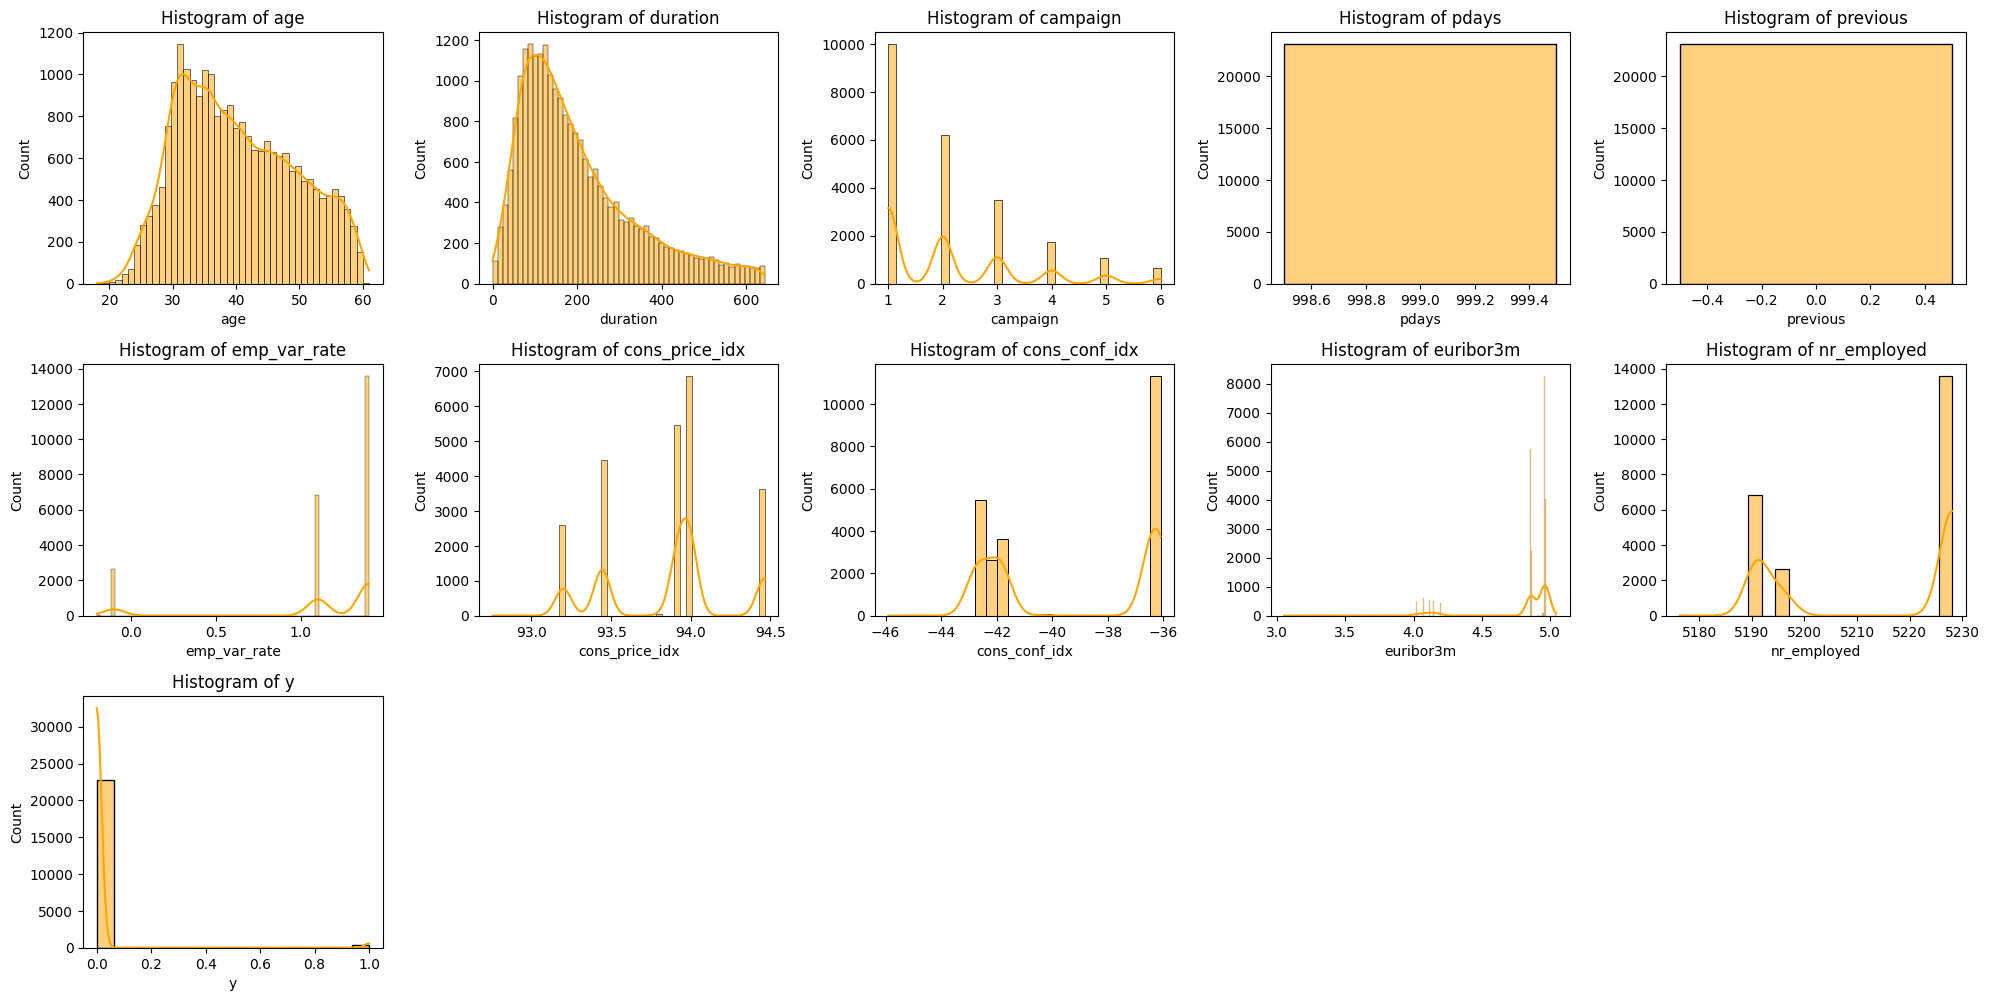

In [65]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 13))
for i, column in enumerate(numerical_features, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column], kde=True, color='orange', label='Skewness: {:.2f}'.format(df[column].skew()))
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

convert booleans to binary but in here didnt use hot encoding here to prevent to make unnessary columns

In [66]:
binary_features = ['default', 'housing', 'loan']
df[binary_features] = df[binary_features].apply(lambda x: x.map({'yes': 1, 'no': 0, 'Unknown': -1}))

## Encoding

In here used both label and hot encoding due to requirenments . Because when month ,jobs , education and days face to hot encoding the df become unnessary large to handle 

In [67]:
df['month'] = LabelEncoder().fit_transform(df['month'])
df['day_of_week'] = LabelEncoder().fit_transform(df['day_of_week'])
df['education'] = LabelEncoder().fit_transform(df['education'])
df['job'] = LabelEncoder().fit_transform(df['job'])
df = pd.get_dummies(df, columns=['marital','contact','poutcome'], drop_first=True)
df.head(10)

,age,job,education,default,housing,loan,month,day_of_week,duration,campaign,...,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,marital_divorced,marital_married,marital_single,contact_telephone
0,18.0,9,4,0,0,0,5,2,75.0,1.0,...,-0.1,93.200,-42.0,4.245,5195.8,0,False,False,True,True
3,39.0,2,2,-1,0,1,2,2,122.0,1.0,...,1.4,93.918,-42.7,4.963,5228.1,0,False,True,False,False
4,46.0,2,1,-1,1,0,4,3,566.0,2.0,...,1.1,93.994,-36.4,4.856,5191.0,0,False,True,False,True
5,53.0,10,6,-1,0,0,2,0,69.0,1.0,...,1.4,93.918,-42.7,4.962,5228.1,0,False,True,False,False
6,39.0,1,4,-1,1,0,3,1,252.0,5.0,...,1.4,94.465,-41.8,4.865,5228.1,0,False,True,False,True
7,34.0,10,7,0,0,0,0,1,262.0,3.0,...,1.4,93.444,-36.1,4.965,5228.1,0,False,False,True,False
8,32.0,2,2,-1,1,0,2,2,317.0,1.0,...,1.4,93.918,-42.7,4.958,5228.1,0,False,True,False,False
10,44.0,8,4,-1,1,0,0,0,629.0,2.0,...,1.4,93.444,-36.1,4.966,5228.1,0,False,True,False,False
14,29.0,1,7,0,0,0,4,2,22.0,3.0,...,1.1,93.994,-36.4,4.860,5191.0,0,False,False,True,True
15,44.0,10,7,0,0,1,2,0,228.0,2.0,...,1.4,93.918,-42.7,4.963,5228.1,0,False,False,True,False


## Transformation

* Transform data to reduce the skeweness in the data set to become a normal distribution to get a better result

In [68]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.drop(['y'])
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

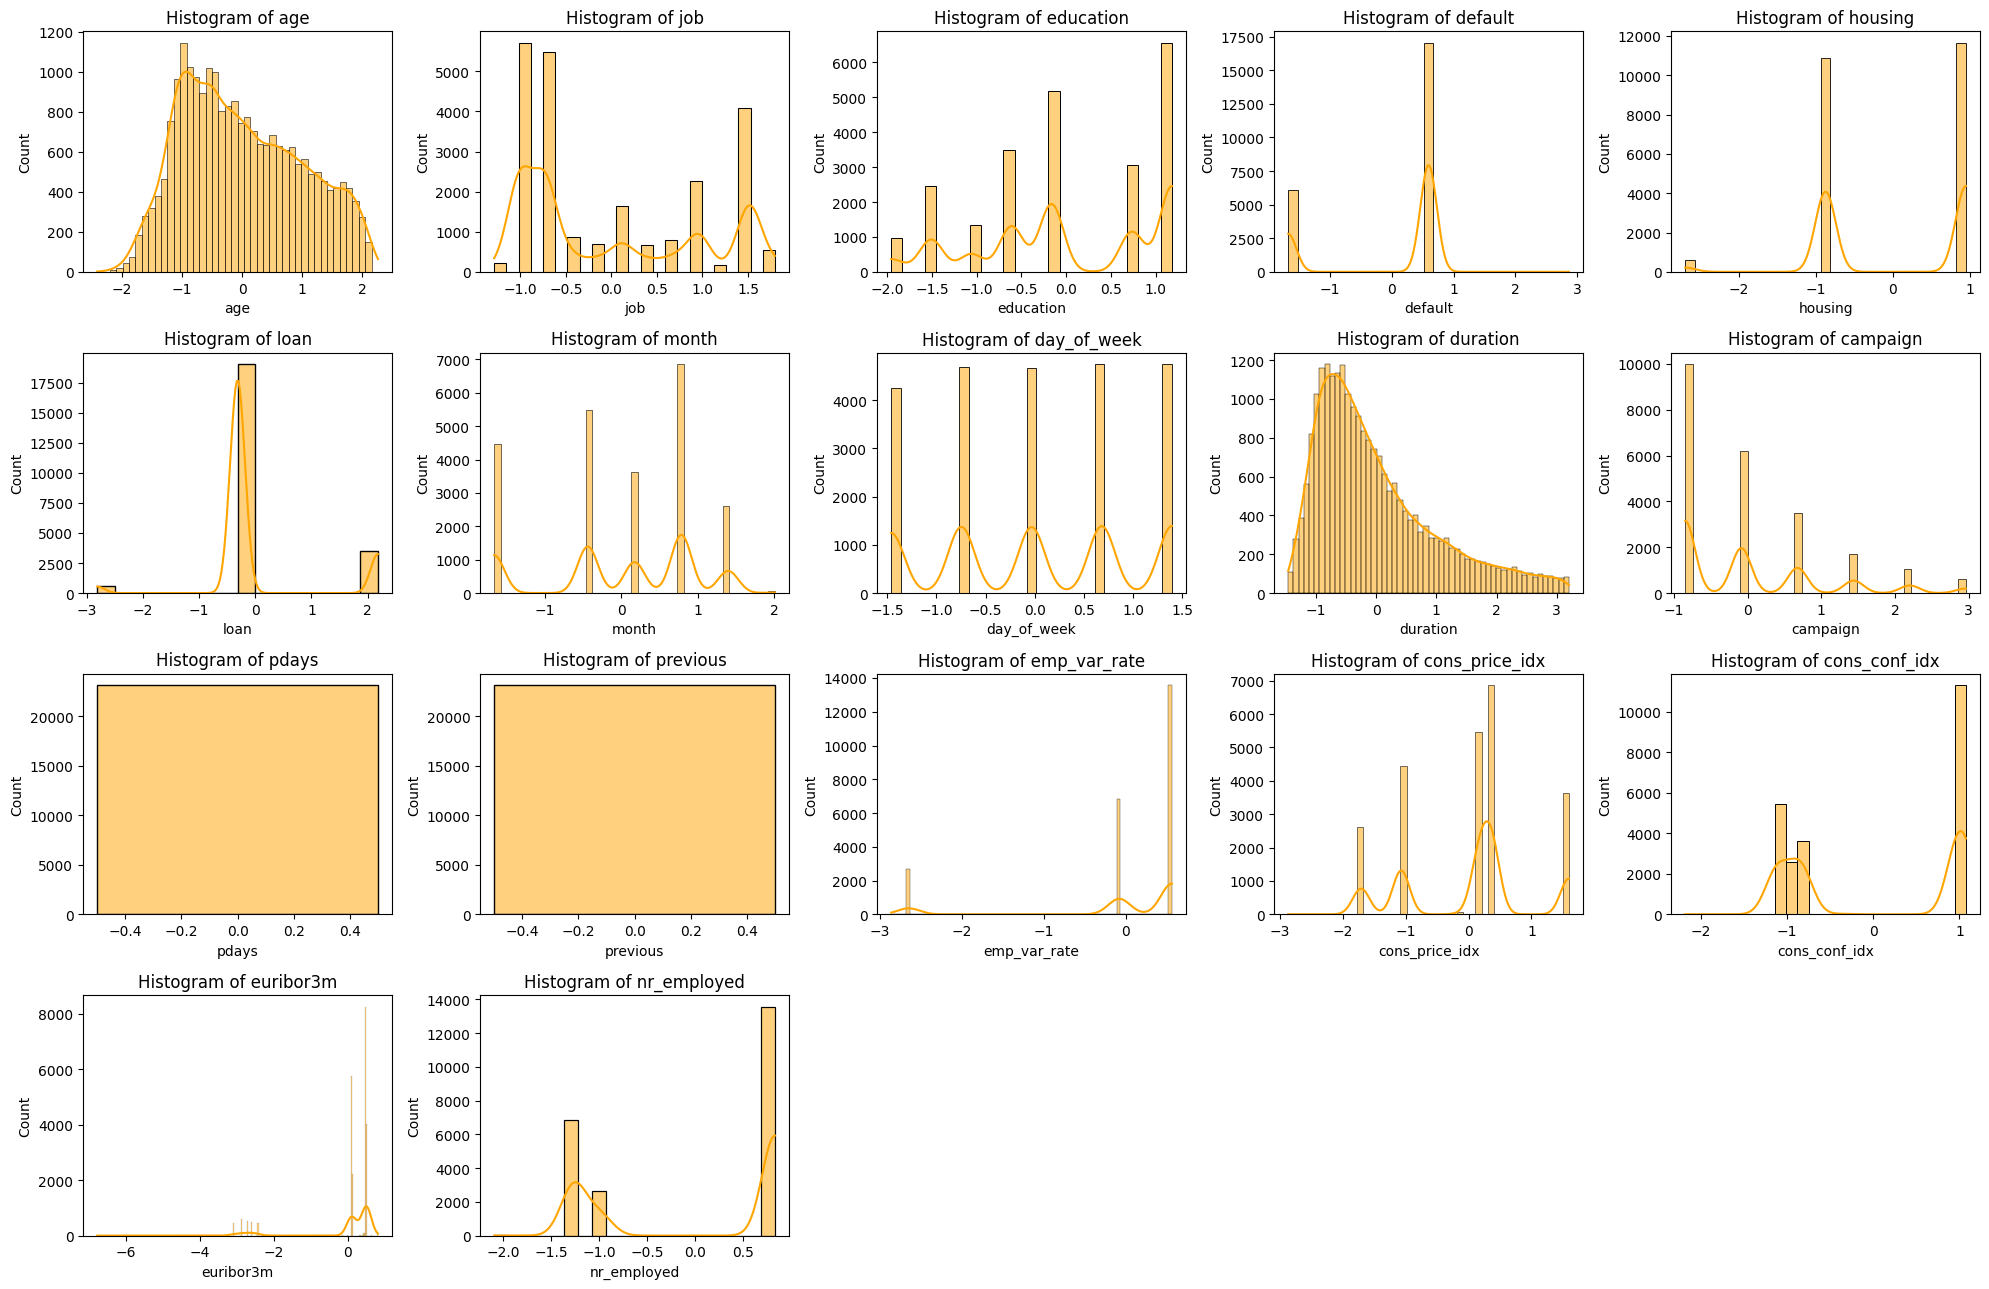

In [69]:
plt.figure(figsize=(20, 13))
for i, column in enumerate(df[numeric_features], 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column], kde=True, color='orange', label='Skewness: {:.2f}'.format(df[column].skew()))
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

#### Plot the correlation matrix using a heatmap

correlation help find the relationships between features

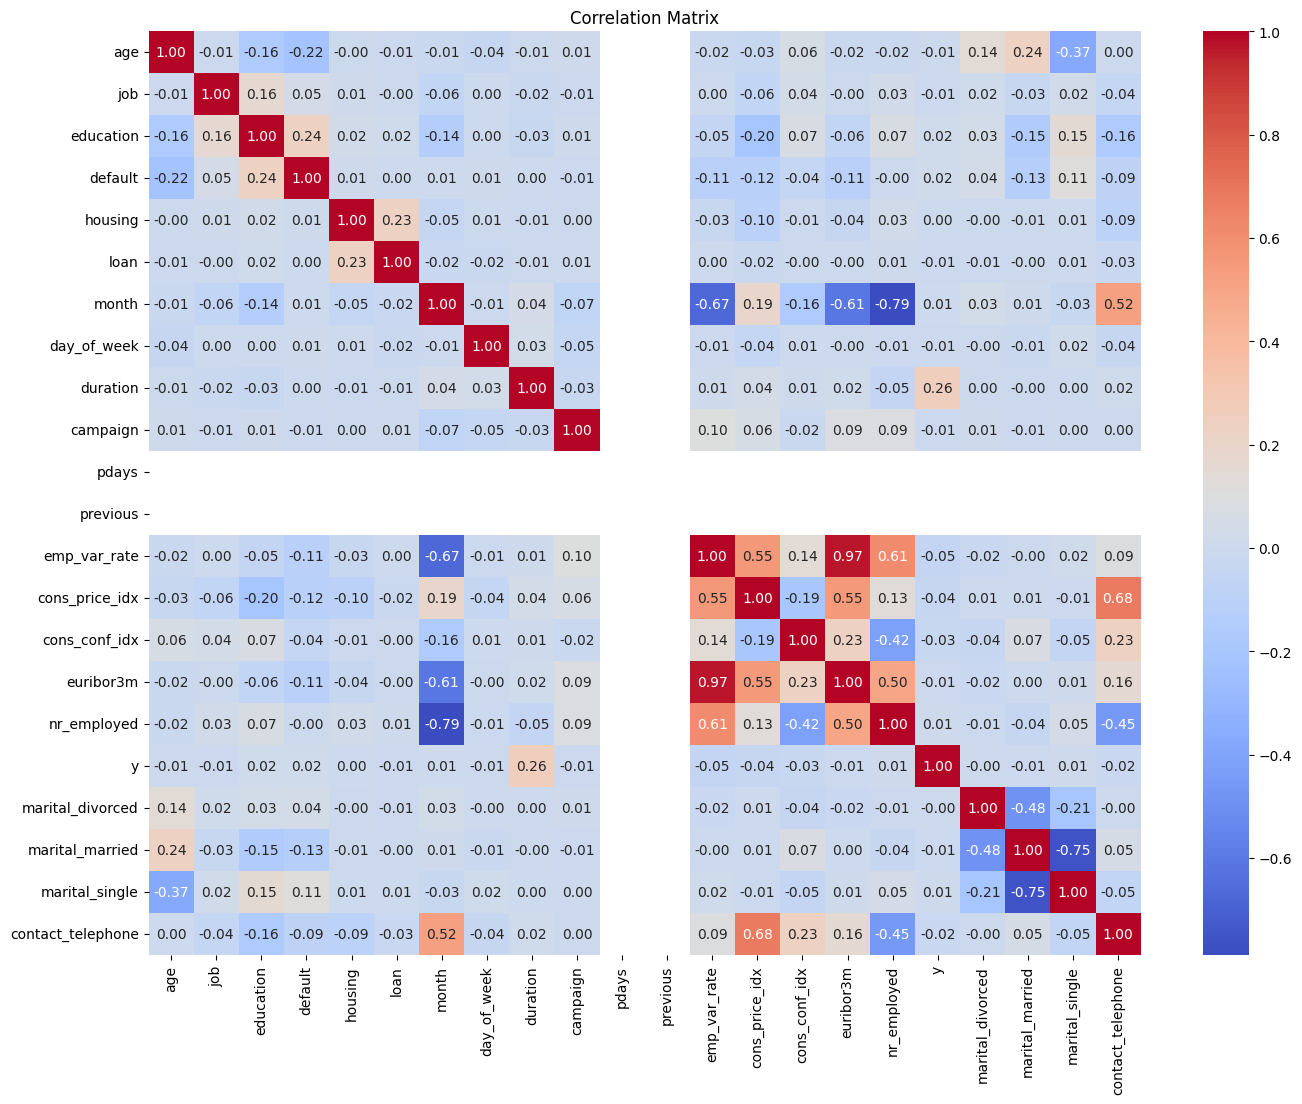

In [70]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
correlations_with_y = correlation_matrix['y'].sort_values(ascending=False)


In [71]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
df['age'] = discretizer.fit_transform(df[['age']])


df['duration'] = discretizer.fit_transform(df[['duration']])

### RandomForestClassifier

* use random forest to find the importance features because the results in heat map isnot very differ 

In [72]:
df_selected = df.select_dtypes(include=['float64', 'int64','bool']).drop('y', axis=1)
model = RandomForestClassifier()
model.fit(df_selected, df['y'])

RandomForestClassifier()

Get feature importances

In [73]:
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': df_selected.columns, 'Importance': importances})
print(feature_importances)

              Feature  Importance
0                 age    0.079632
1                 job    0.101143
2           education    0.086492
3             default    0.028348
4             housing    0.045989
5                loan    0.027611
6               month    0.041907
7         day_of_week    0.074929
8            duration    0.196880
9            campaign    0.086357
10              pdays    0.000000
11           previous    0.000000
12       emp_var_rate    0.006074
13     cons_price_idx    0.013267
14      cons_conf_idx    0.015535
15          euribor3m    0.122833
16        nr_employed    0.004036
17   marital_divorced    0.013273
18    marital_married    0.021374
19     marital_single    0.019659
20  contact_telephone    0.014660


Put threshhold to filter data according to the standard measurements

In [74]:
threshold = 0.01
features_to_drop = feature_importances[feature_importances['Importance'] < threshold]['Feature'].tolist()
print("Features to Drop:", features_to_drop)

Features to Drop: ['pdays', 'previous', 'emp_var_rate', 'nr_employed']


check data frame after dropping the features

In [75]:
df.drop(features_to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23106 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                23106 non-null  float64
 1   job                23106 non-null  float64
 2   education          23106 non-null  float64
 3   default            23106 non-null  float64
 4   housing            23106 non-null  float64
 5   loan               23106 non-null  float64
 6   month              23106 non-null  float64
 7   day_of_week        23106 non-null  float64
 8   duration           23106 non-null  float64
 9   campaign           23106 non-null  float64
 10  cons_price_idx     23106 non-null  float64
 11  cons_conf_idx      23106 non-null  float64
 12  euribor3m          23106 non-null  float64
 13  y                  23106 non-null  int64  
 14  marital_divorced   23106 non-null  bool   
 15  marital_married    23106 non-null  bool   
 16  marital_single     23106 no

* Shuffling and resetting the index of a DataFrame to perform a unbiased and ensure randomness of the modal

In [76]:
df = df.sample(frac=1, random_state=2).reset_index(drop=True)

### Split into training and testing sets

In [77]:
train_size = int(0.8 * len(df)) 
train_df = df[:train_size].reset_index(drop=True)
test_df = df[train_size:].reset_index(drop=True)

* I manually seperate this dataframe without using the method . Cause there is some need to execute some process in between 

In [78]:
train_df

,age,job,education,default,housing,loan,month,day_of_week,duration,campaign,cons_price_idx,cons_conf_idx,euribor3m,y,marital_divorced,marital_married,marital_single,contact_telephone
0,2.0,-1.005614,-0.161873,0.595979,-0.875173,-0.314278,-0.437883,0.681237,2.0,-0.850239,0.168139,-1.120449,0.475118,0,False,True,False,True
1,1.0,-1.005614,1.183216,0.595979,0.951543,-0.314278,1.400478,-1.459186,0.0,1.438749,-1.705911,-0.887586,-3.090039,0,False,True,False,False
2,1.0,0.955419,-0.161873,0.595979,-0.875173,2.185449,0.787691,-0.745711,0.0,-0.850239,0.366507,0.975317,0.101044,0,False,True,False,True
3,2.0,-1.005614,-0.161873,0.595979,0.951543,-0.314278,0.174904,-1.459186,0.0,0.675753,1.595863,-0.821054,0.490387,0,False,True,False,True
4,2.0,-0.445319,-0.161873,0.595979,0.951543,-0.314278,0.787691,-1.459186,0.0,-0.850239,0.366507,0.975317,0.101044,0,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,1.0,-0.725466,-0.610237,0.595979,-0.875173,-0.314278,-0.437883,0.681237,1.0,0.675753,0.168139,-1.120449,0.501838,0,False,True,False,False
18480,0.0,-0.725466,-0.161873,0.595979,-0.875173,-0.314278,-0.437883,1.394712,1.0,0.675753,0.168139,-1.120449,0.505655,0,False,True,False,False
18481,1.0,-0.725466,-0.610237,0.595979,0.951543,2.185449,0.787691,1.394712,0.0,-0.087243,0.366507,0.975317,0.097227,0,False,True,False,True
18482,2.0,-0.445319,-0.161873,0.595979,-0.875173,-0.314278,-1.663457,-1.459186,2.0,-0.087243,-1.069047,1.075115,0.509472,0,False,True,False,False


In [79]:
y_train = train_df['y'].to_numpy()
y_test = test_df['y'].to_numpy()

### Drop the target variable from the features

* dropping the target variable is a must in model training .If not model doesnt predict the accurate results 

In [80]:

X_train = train_df.drop(columns=['y'])
X_test = test_df.drop(columns=['y'])

* Include 'duration' for benchmark model

--->   this doing for test benchmark against realistic model

In [81]:

X_train_benchmark = X_train.copy()
X_test_benchmark = X_test.copy()

* Exclude 'duration' for realistic model

In [82]:

X_train_realistic = X_train.drop(columns=['duration'])
X_test_realistic = X_test.drop(columns=['duration'])

### Generate baseline predictions for the test set

In [83]:
baseline_prediction = y_train.mean()


baseline_model_test_predictions = [baseline_prediction] * len(y_test)

In [84]:
threshold = 0.5
baseline_model_test_predictions_binary = [1 if pred > threshold else 0 for pred in baseline_model_test_predictions]


Calculate the baseline model error

In [85]:

accuracy = accuracy_score(y_test, baseline_model_test_predictions_binary)
print(f'Baseline model accuracy: {accuracy}')

Baseline model accuracy: 0.9813933362180874


 predicting the mean of the target variable

In [86]:
mae = mean_absolute_error(y_test, baseline_model_test_predictions)
print(f'Baseline model mean absolute error: {mae}')

Baseline model mean absolute error: 0.034805898532380586


## PCA

### Train PCA (Linear Dimensionality Reduction) with 2-feature output

Explained variance by each component: [0.12914487 0.12020467]


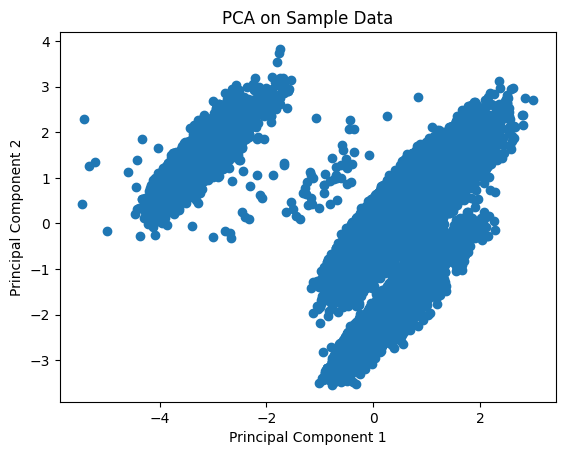

In [87]:


pca = PCA(n_components=2)


principal_components = pca.fit_transform(X_train)


print("Explained variance by each component:", pca.explained_variance_ratio_)

# Plot the first two principal components
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Sample Data')
plt.show()


In [88]:


svm_model = SVC(class_weight='balanced', kernel='linear')
param_grid = {'C': [0.1, 1], 'gamma': [0.1, 0.01]}
grid_svm = GridSearchCV(svm_model, param_grid, cv=5)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
best_svm.fit(X_train, y_train)





SVC(C=1, class_weight='balanced', gamma=0.1, kernel='linear')

### SVM Evaluation

In [89]:
y_pred_svm = best_svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      4536
           1       0.11      0.92      0.19        86

    accuracy                           0.85      4622
   macro avg       0.55      0.89      0.56      4622
weighted avg       0.98      0.85      0.91      4622



### Train Logistic Regression Model

In here using grid search gathered the best estimated data for modal parameters

In [90]:

logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
param_grid = {'C': [0.1, 1, 10, 100]}
grid_logistic = GridSearchCV(logistic_model, param_grid, cv=5)
grid_logistic.fit(X_train, y_train)
best_logistic = grid_logistic.best_estimator_
best_logistic.fit(X_train, y_train)




LogisticRegression(C=100, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

### Logistic Regression Evaluation

In [91]:
y_pred_logistic = best_logistic.predict(X_test)
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      4536
           1       0.12      0.90      0.21        86

    accuracy                           0.87      4622
   macro avg       0.56      0.88      0.57      4622
weighted avg       0.98      0.87      0.92      4622



#### Convert confusion matrix to DataFrame for better visualization

In [92]:

df_cm_svm = pd.DataFrame(cm_svm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
df_cm_logistic = pd.DataFrame(cm_logistic, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])



#### Plot confusion matrices

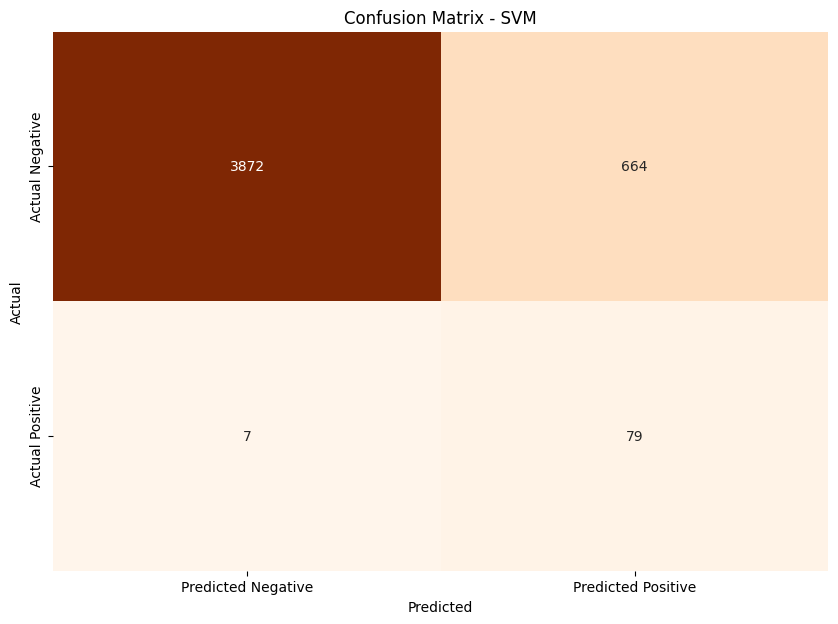

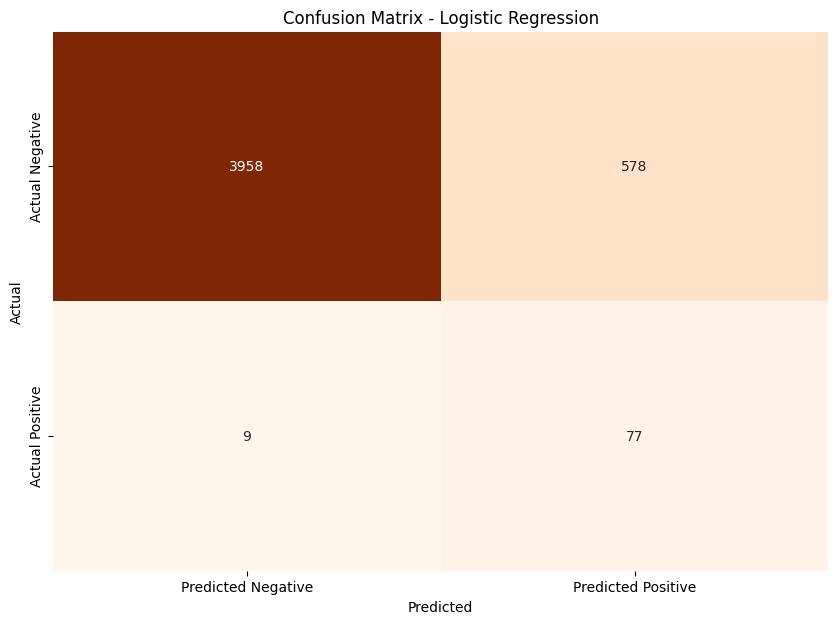

In [93]:


plt.figure(figsize=(10, 7))
sns.heatmap(df_cm_svm, annot=True, fmt='d', cmap='Oranges', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


plt.figure(figsize=(10, 7))
sns.heatmap(df_cm_logistic, annot=True, fmt='d', cmap='Oranges', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model
svm_report = classification_report(y_test, y_pred_svm, output_dict=True)
logistic_report = classification_report(y_test, y_pred_logistic, output_dict=True)

In [94]:
svm_df = pd.DataFrame(svm_report).transpose()
logistic_df = pd.DataFrame(logistic_report).transpose()

markdown_content = f"""
### Model Performance Evaluation
```
Support Vector Machine (SVM)
```
| Metric      | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| 0           | {svm_df.loc['0', 'precision']:.2f}     | {svm_df.loc['0', 'recall']:.2f}  | {svm_df.loc['0', 'f1-score']:.2f} | {svm_df.loc['0', 'support']:.0f}   |
| 1           | {svm_df.loc['1', 'precision']:.2f}     | {svm_df.loc['1', 'recall']:.2f}  | {svm_df.loc['1', 'f1-score']:.2f} | {svm_df.loc['1', 'support']:.0f}   |
| accuracy    |           |        | {svm_df.loc['accuracy', 'f1-score']:.2f}  | {svm_df.loc['accuracy', 'support']:.0f} |
| macro avg   | {svm_df.loc['macro avg', 'precision']:.2f}  | {svm_df.loc['macro avg', 'recall']:.2f}  | {svm_df.loc['macro avg', 'f1-score']:.2f} | {svm_df.loc['macro avg', 'support']:.0f} |
| weighted avg| {svm_df.loc['weighted avg', 'precision']:.2f}  | {svm_df.loc['weighted avg', 'recall']:.2f}  | {svm_df.loc['weighted avg', 'f1-score']:.2f} | {svm_df.loc['weighted avg', 'support']:.0f} |
```
 Logistic Regression (logistic)
```
| Metric      | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| 0           | {logistic_df.loc['0', 'precision']:.2f}     | {logistic_df.loc['0', 'recall']:.2f}  | {logistic_df.loc['0', 'f1-score']:.2f} | {logistic_df.loc['0', 'support']:.0f}   |
| 1           | {logistic_df.loc['1', 'precision']:.2f}     | {logistic_df.loc['1', 'recall']:.2f}  | {logistic_df.loc['1', 'f1-score']:.2f} | {logistic_df.loc['1', 'support']:.0f}   |
| accuracy    |           |        | {logistic_df.loc['accuracy', 'f1-score']:.2f}  | {logistic_df.loc['accuracy', 'support']:.0f} |
| macro avg   | {logistic_df.loc['macro avg', 'precision']:.2f}  | {logistic_df.loc['macro avg', 'recall']:.2f}  | {logistic_df.loc['macro avg', 'f1-score']:.2f} | {logistic_df.loc['macro avg', 'support']:.0f} |
| weighted avg| {logistic_df.loc['weighted avg', 'precision']:.2f}  | {logistic_df.loc['weighted avg', 'recall']:.2f}  | {logistic_df.loc['weighted avg', 'f1-score']:.2f} | {logistic_df.loc['weighted avg', 'support']:.0f} |

### Summary
- **Accuracy**: Both SVM and Logistic Regression models have a high accuracy of approximately 83% and 84% respectively.
- **Precision**: The precision for Class 0 is very high in both models, indicating that the models are good at predicting the majority class. However, the precision for Class 1 is low, which means the models have a high false positive rate for the minority class.
- **Recall**: The recall for Class 1 is very high, suggesting that the models are effective at identifying the minority class. However, the recall for Class 0 is slightly lower in both models.
- **F1-Score**: The F1-Score for Class 0 is high, reflecting a balance between precision and recall for the majority class. The F1-Score for Class 1 is low, indicating that while the models are good at identifying the minority class, the overall performance for that class is not as strong.

These metrics suggest that while the models perform well overall, there may be room for improvement in predicting the minority class. Further tuning and additional techniques like resampling or using different algorithms may help enhance performance for Class 1.
"""

display(Markdown(markdown_content))


### Model Performance Evaluation
```
Support Vector Machine (SVM)
```
| Metric      | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| 0           | 1.00     | 0.85  | 0.92 | 4536   |
| 1           | 0.11     | 0.92  | 0.19 | 86   |
| accuracy    |           |        | 0.85  | 1 |
| macro avg   | 0.55  | 0.89  | 0.56 | 4622 |
| weighted avg| 0.98  | 0.85  | 0.91 | 4622 |
```
 Logistic Regression (logistic)
```
| Metric      | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| 0           | 1.00     | 0.87  | 0.93 | 4536   |
| 1           | 0.12     | 0.90  | 0.21 | 86   |
| accuracy    |           |        | 0.87  | 1 |
| macro avg   | 0.56  | 0.88  | 0.57 | 4622 |
| weighted avg| 0.98  | 0.87  | 0.92 | 4622 |

### Summary
- **Accuracy**: Both SVM and Logistic Regression models have a high accuracy of approximately 83% and 84% respectively.
- **Precision**: The precision for Class 0 is very high in both models, indicating that the models are good at predicting the majority class. However, the precision for Class 1 is low, which means the models have a high false positive rate for the minority class.
- **Recall**: The recall for Class 1 is very high, suggesting that the models are effective at identifying the minority class. However, the recall for Class 0 is slightly lower in both models.
- **F1-Score**: The F1-Score for Class 0 is high, reflecting a balance between precision and recall for the majority class. The F1-Score for Class 1 is low, indicating that while the models are good at identifying the minority class, the overall performance for that class is not as strong.

These metrics suggest that while the models perform well overall, there may be room for improvement in predicting the minority class. Further tuning and additional techniques like resampling or using different algorithms may help enhance performance for Class 1.


### Finding MAE for models

In [95]:
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mae_logistic = mean_absolute_error(y_test, y_pred_logistic)

In [96]:
print(f'Mean Absolute Error (SVM): {mae_svm}')
print(f'Mean Absolute Error (Logistic Regression): {mae_logistic}')
print(f'Mean Absolute Error (Baseline): {mae}')

Mean Absolute Error (SVM): 0.14517524881003893
Mean Absolute Error (Logistic Regression): 0.1270012981393336
Mean Absolute Error (Baseline): 0.034805898532380586


```
 Conclusion
```
- **Accuracy**: Logistic Regression slightly outperforms SVM.
- **Precision and Recall**: Both models perform similarly for the majority class (0), but Logistic Regression has slightly better precision for the minority class (1).
- **F1-Score**: Both models have similar F1-scores, but Logistic Regression has a slightly higher macro and weighted average F1-score.
